## A Keras implementation of the SegNet architecture
## This notebook was a project for the Deep Learning course

In this project we will try to create an image segmentation convolutional neural network model

In [1]:
from segnet import *
from utils import *
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
import IPython
%matplotlib inline

Using TensorFlow backend.


# SegNet architecture - Pixel Wise Segmentation

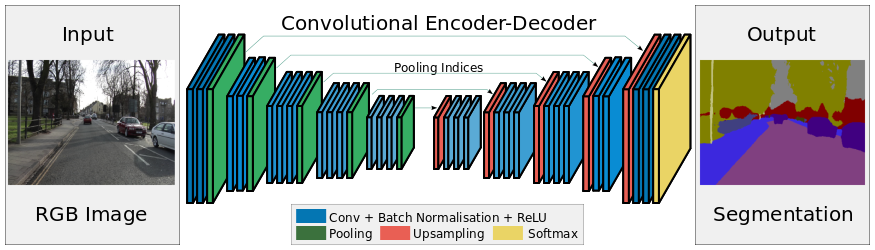

In [85]:
Image(filename="../Convolution project 2/pics/segnet.png",
     width=1000,height=320)

## Loading Images

In [2]:
img_size = (360,480)

img_path = './CamVid/train'
mask_path = './CamVid/trainannot'
val_path = './CamVid/val'
val_masks = './CamVid/valannot'

X_train = load_images(img_size[0],img_size[1],img_path= img_path)
X_train_masks = load_images(img_size[0],img_size[1],img_path=mask_path)
X_val = load_images(img_size[0],img_size[1],val_path)
X_val_masks = load_images(img_size[0],img_size[1],val_masks)



100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 768.23it/s]


#### You can define whatever classes you want as long as you have their pixel values

In [3]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

# We dont want to classify unlabelled.it will only make our dataset more unbalanced than it already is
label_values = [Sky,Building,Pole,Road_marking,Road,Pavement,Tree,
                SignSymbol,Fence,Car,Pedestrian,Bicyclist,Unlabelled]

In [30]:
X_train_norm = [equalize_hist(X_train[i]) for i in range(len(X_train))]
X_val_norm = [equalize_hist(X_val[i]) for i in range(len(X_val))]
X_train_norm = np.array(X_train_norm)
X_val_norm = np.array(X_val_norm)
# np.save("C:/Users/User/Desktop/Training/X_train.npy",X_train_norm)
# np.save("C:/Users/User/Desktop/Training/X_val_norm.npy",X_val_norm)

In [5]:
y_train_norm = [one_hot_it(X_train_masks[i],label_values) for i in range(len(X_train_masks))]
y_train_val = [one_hot_it(X_val_masks[i],label_values) for i in range(len(X_val_masks))]
y_train_norm = np.array(y_train_norm)
y_train_val = np.array(y_train_val)


np.save("C:/Users/User/Desktop/Training/y_train.npy",y_train_norm)
np.save("C:/Users/User/Desktop/Training/y_val.npy",y_train_val)

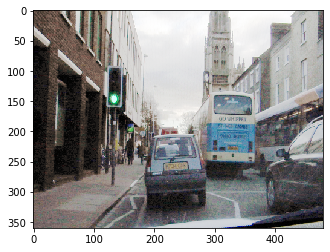

In [45]:
from keras.preprocessing.image import array_to_img
img = array_to_img(X_train_norm[0])
plt.imshow(img)

## Training Segnet with whole dataset and weighting. 
## Use of median frequency balancing 

In [4]:
X_train = np.load("C:/Users/User/Desktop/Training/X_train.npy")
y_train_norm = np.load("C:/Users/User/Desktop/Training/y_train.npy")
X_val = np.load("C:/Users/User/Desktop/Training/X_val_norm.npy")
y_val = np.load("C:/Users/User/Desktop/Training/y_val.npy")

In [47]:
X_oh = reverse_one_hot(y_train_norm)
weights = median_frequency_balancing(X_oh)

In [7]:
fpathmodel="C:/Users/User/Desktop/logseg/seg1.hdf5"
cp = ModelCheckpoint(fpathmodel, monitor='acc', verbose=2, save_best_only=True, mode='min') #Keep Model
callbacks_list = [cp,PlotLossesCallback()]

In [2]:
%run ./py/segnet.py

Using TensorFlow backend.


In [8]:
seg = segnet(img_size=(360,480,3),classes=12,optimizer='adadelta',loss_function='categorical_crossentropy',metric=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 360, 480, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 240, 128)     147584    
_________________________________________________________________
bloc

In [10]:
y_train_norm = y_train_norm.reshape((y_train_norm.shape[0],y_train_norm.shape[1]*y_train_norm.shape[2],
                                    y_train_norm.shape[3]))

y_val = y_val.reshape((y_val.shape[0],y_val.shape[1]*y_val.shape[2],
                                    y_val.shape[3]))

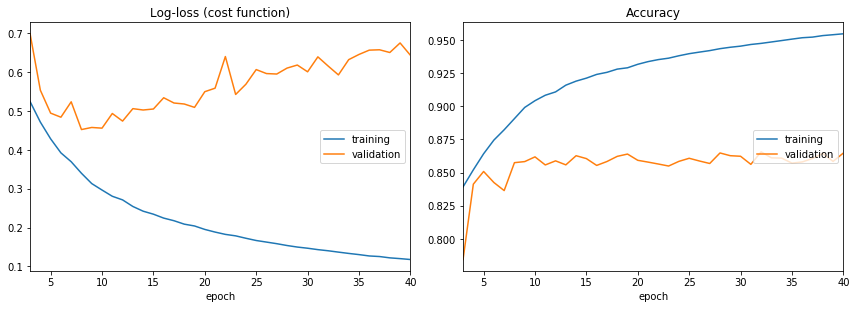

Log-loss (cost function):
training   (min:    0.118, max:    0.832, cur:    0.118)
validation (min:    0.452, max:    0.849, cur:    0.644)

Accuracy:
training   (min:    0.750, max:    0.955, cur:    0.955)
validation (min:    0.760, max:    0.866, cur:    0.865)


In [14]:
seg.fit(X_train,y_train_norm, 
                  validation_data=(X_val,y_val),batch_size=1,shuffle=True,
                  epochs=40, verbose=1, callbacks=callbacks_list,class_weight=weights)

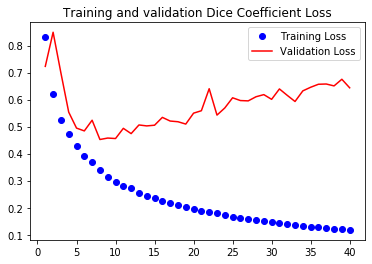

<Figure size 432x288 with 0 Axes>

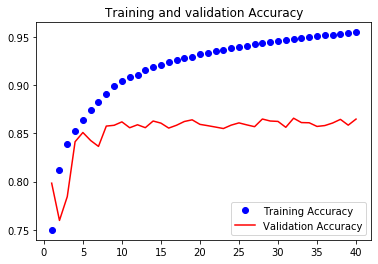

<Figure size 432x288 with 0 Axes>

In [23]:
loss = seg.history.history['loss']
val_loss = seg.history.history['val_loss']
acc = seg.history.history['acc']
val_acc = seg.history.history['val_acc']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label = 'Training Loss')
plt.plot(epochs,val_loss ,'b',label = 'Validation Loss' ,color = 'r')
plt.title('Training and validation Dice Coefficient Loss')
plt.legend()
plt.show()

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc ,'b',label = 'Validation Accuracy' ,color = 'r')
plt.title('Training and validation Accuracy')
plt.legend()


plt.figure()

In [15]:
seg.save('C:/Users/User/Desktop/logseg/Segnetfully.h5')

In [ ]:
model = load_model('C:/Users/User/Desktop/logseg/Segnetfully.h5')

In [16]:
#load best model
# model = load_model("C:/Users/User/Desktop/logseg/seg1.hdf5")

See results on train

In [6]:
#Make predictions
y_prob = model.predict(X_train[:5])

#Output the most probable classes based on predictions
y_classes = y_prob.argmax(axis=-1)

#Reshape our classes in order to proceed with visualizing our predictions
y_classes = y_classes.reshape(y_classes.shape[0],360,480)

#### Visualizing Predictions

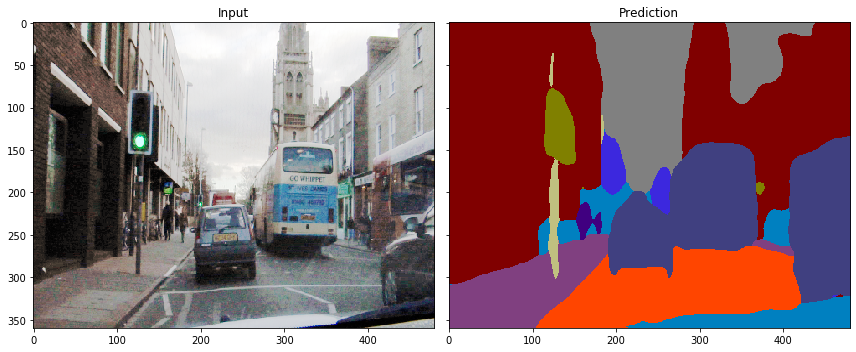

In [20]:
segment = colour_code_segmentation(y_classes,label_values)

plot_predictions(X_train[1],segment[1],path="3")

See results on val

In [21]:
#Make predictions
y_prob = seg.predict(X_val[:5])

#Output the most probable classes based on predictions
y_classes = y_prob.argmax(axis=-1)

#Reshape our classes in order to proceed with visualizing our predictions
y_classes = y_classes.reshape(y_classes.shape[0],360,480)

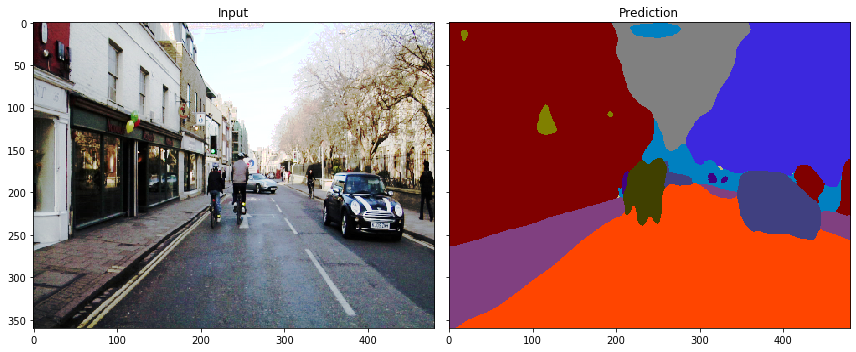

In [22]:
segment = colour_code_segmentation(y_classes,label_values)

plot_predictions(X_val[1],segment[1],path="3")